In [8]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import os

DATA_DIR = "/content/drive/MyDrive"

os.chdir(DATA_DIR)
os.getcwd()

'/content/drive/MyDrive'

In [1]:
%pip install transformers datasets torch scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [10]:
df = pd.read_csv("final_dataset.csv")
df = df.dropna()
df = df.rename(columns={"type": "label"})
df

,text,source,formality,label
0,delegation peru greatly pleased sir election p...,un_debates,formal,spoken
1,webvtt kind captions language en want video tr...,khan_academy,educational,spoken
2,congratulate mr president assuming responsible...,un_debates,formal,spoken
3,well called c chosen,telephone_convos,informal,spoken
4,regards janine cash vi confirmation request ka...,enron_emails,formal,written
...,...,...,...,...
2838,hi baby im sat bloody bus mo wont home wanna s...,sms,informal,written
2839,rents havent looked rents long time,telephone_convos,informal,spoken
2840,forgetting hurts knowing decision take sometim...,medium,semiformal,written
2841,created prototypes played friends encouraged t...,medium,semiformal,written


In [11]:
import pandas as pd

selected_columns = ["text", "label"]
df_subset = df[selected_columns]

#randomly select
df_sampled = df_subset.sample(n=500, random_state=42)

df_sampled = df_sampled.reset_index(drop=True)

print(df_sampled.head())

                                                text    label
0  madam secretary please close voting results ey...   spoken
1      ugh hopefully asus ppl dont randomly reformat  written
2  wanted wish happy new year wanted talk legal a...  written
3                          okay ive seen pick friday  written
4  like express sincere congratulations mr gurira...   spoken


In [12]:
id2label = {0: "written", 1: "spoken"}
label2id = {"written": 0, "spoken": 1}

In [13]:
df_sampled["label"] = df_sampled["label"].map(label2id)

In [20]:
dataset = Dataset.from_pandas(df_sampled)
# plit into train/test sets
dataset = dataset.train_test_split(test_size=0.2)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

In [21]:
train_dataset[0]

{'text': 'yeah think youre right f uh role make everybody like us', 'label': 1}

In [31]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# Apply tokenization
train_dataset = train_dataset.map(preprocess_function, batched=True)
eval_dataset = eval_dataset.map(preprocess_function, batched=True)


Map: 100%|██████████| 100/100 [00:00<00:00, 835.37 examples/s]


In [32]:
train_dataset['label'][0]

1

In [33]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
!pip install evaluate

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [34]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(train_dataset) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [35]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [36]:
tf_train_set = model.prepare_tf_dataset(
    train_dataset,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    eval_dataset,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [37]:
import tensorflow as tf

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [38]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [39]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [ ]:
!pip install wandb

In [ ]:
! wandb login
# API KEY = 8544b034b0ba783804d4ba2d8bcdbeb3fe2de75c

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shivanipuli (shivanipuli-university-of-chicago) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [40]:
import wandb
from transformers import TrainingArguments

wandb.init(project="bert-written-classification")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./hugging_face_bert_classifier",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    report_to="wandb",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    load_best_model_at_end=True,
)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/cs257_hw1/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [41]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/var/folders/fs/jcn2l7y55m7ghn968jcnxtn00000gn/T/ipykernel_19078/3596171536.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [42]:
eval_results = trainer.evaluate()
print(eval_results)

In [ ]:
!pip install transformers torch shap


In [43]:
import os
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments
model_path = "final_bert_model"
config = AutoConfig.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                           config=config,
                                                           torch_dtype=torch.float32,
                                                           trust_remote_code=True)

In [44]:
eval_results = trainer.evaluate()
print(eval_results)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


{'eval_loss': 0.6745584607124329, 'eval_model_preparation_time': 0.002, 'eval_accuracy': 0.62, 'eval_precision': 0.4849645390070922, 'eval_recall': 0.62, 'eval_f1': 0.52025, 'eval_runtime': 14.245, 'eval_samples_per_second': 7.02, 'eval_steps_per_second': 0.491}


## Classification Example

In [53]:
import torch

text = "Uh, so, like, I think this might be, you know, a good idea."
inputs = tokenizer(text, return_tensors="pt")

model.eval()
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
print(f"Predicted Label: {id2label[predicted_class_id]}")


Predicted Label: spoken


In [46]:
text = "The contextual evidence relating to the study (often relating to academics) indicates otherwise."
inputs = tokenizer(text, return_tensors="pt")

model.eval()
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
print(f"Predicted Label: {id2label[predicted_class_id]}")

Predicted Label: written


## SHAP Analysis

In [51]:
!pip install shap

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached shap-0.46.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (24 kB)
  Using cached numba-0.61.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached llvmlite-0.44.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (4.8 kB)
Using cached shap-0.46.0-cp311-cp311-macosx_11_0_arm64.whl (455 kB)
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)
Using cached numba-0.61.0-cp311-cp311-macosx_11_0_arm64.whl (2.8 MB)
Using cached llvmlite-0.44.0-cp311-cp311-macosx_11_0_arm64.whl (26.2 MB)


In [54]:
import pandas as pd
import shap
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

data = {
    'text': ["Our delegation worked very closely with Mr. Deiss, and we can testify to his exceptional commitment to the United Nations and his immense capacity for work", " Divorce, or judicial separation, is governed by the Matrimonial Causes Act and the Subordinate Courts (Maintenance and Separation) Act, but these acts are only applicable to civil, Christian and Hindu marriages."]
}
df = pd.DataFrame(data)

#model_path = "/final_bert_model"  # Changed to your saved model path
#model = AutoModelForSequenceClassification.from_pretrained(model_path)
#tokenizer = AutoTokenizer.from_pretrained(model_path)
#model.eval()

def tokenize(texts):
    texts = [str(text) for text in texts]
    return tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

def predict(texts):
    inputs = tokenize(texts)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    return probabilities.numpy()

# conver to strings explicitly
#solved type issue with this:
#  https://discuss.huggingface.co/t/trying-to-use-autotokenizer-with-tensorflow-gives-valueerror-text-input-must-of-type-str-single-example-list-str-batch-or-single-pretokenized-example-or-list-list-str-batch-of-pretokenized-examples/28269
texts_to_explain = [str(text) for text in df['text'].tolist()]

masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(predict, masker)
shap_values = explainer(texts_to_explain)

shap.plots.text(shap_values[0])

PartitionExplainer explainer: 3it [00:18, 18.68s/it]               


## Graphical Analysis

In [55]:
from sklearn.manifold import TSNE
import seaborn as sns

# Extract embeddings from last hidden state
with torch.no_grad():
    inputs = tokenizer(eval_dataset['text'], return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs, output_hidden_states=True)
    embeddings = outputs.hidden_states[-1][:, 0, :].numpy()  # Extract CLS token embeddings

# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


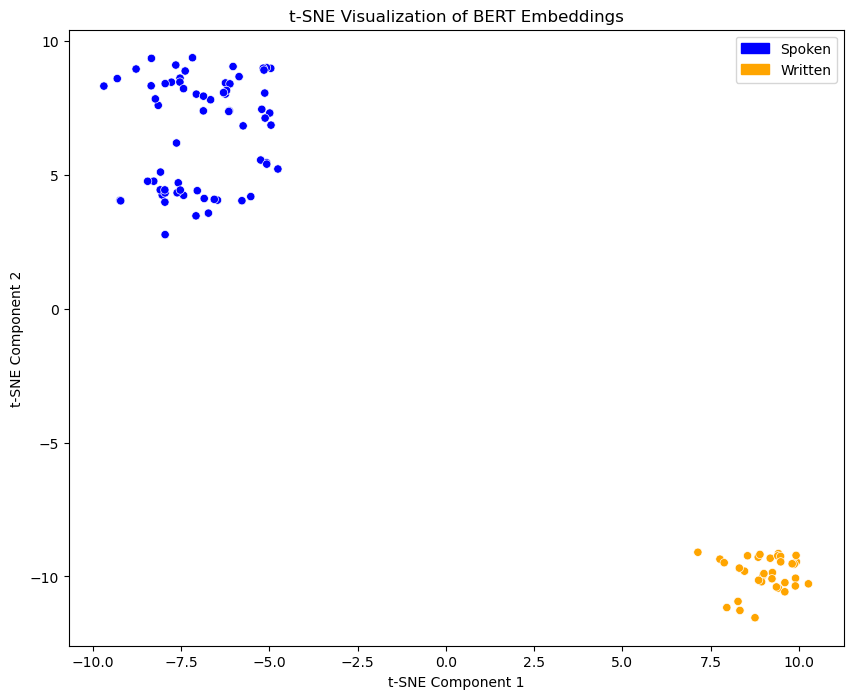

In [57]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Plot embeddings with labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_embeddings[:,0], y=reduced_embeddings[:,1], hue=eval_dataset["label"], palette=["blue", "orange"])
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of BERT Embeddings")
spoken_patch = mpatches.Patch(color="blue", label="Spoken")
written_patch = mpatches.Patch(color="orange", label="Written")

plt.legend(handles=[spoken_patch, written_patch])
plt.show()

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a color palette for different dataset sources
unique_sources = set(eval_dataset["source"])  # Assuming "source" column exists
palette = sns.color_palette("husl", len(unique_sources))  # Generate distinct colors

# Plot embeddings with dataset sources as labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=eval_dataset["source"], palette=palette)

# Labels and title
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of BERT Embeddings by Dataset Source")

# Create legend dynamically based on dataset sources
legend_patches = [mpatches.Patch(color=palette[i], label=source) for i, source in enumerate(unique_sources)]
plt.legend(handles=legend_patches, title="Dataset Source")

# Show plot
plt.show()

KeyError: "Column source not in the dataset. Current columns in the dataset: ['text', 'label', 'input_ids', 'attention_mask']"

## 